# Prediction of time-series 

We use LSTM network for Regression of time-series using also this https://github.com/2wavetech/Time-Series-Analysis-and-Prediction


# Load data

In [22]:

import pandas as pd
import csv
#import plotly.plotly as py
#import plotly.graph_objs as go


filepath = "C:/Users/lyubo/Documents/DATA_networks/patients_data/MonsterMizer-master/MonsterMizerOpenData/"#'C:/Users/tupikina/Documents/Python_Scripts/MonsterMizer-master'

df = pd.read_csv(filepath +'data_patients.csv')
df.head()


,Unnamed: 0,basisPeakSteps,steps,denivelation,kneePain,handsAndFingerPain,foreheadAndEyesPain,forearmElbowPain,aroundEyesPain,shoulderNeckPain,...,walk,roadBike,mountainBike,swimming,surfing,climbing,viaFerrata,alpiSki,downSki,eyeRelatedActivities
0,2015-11-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-11-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-11-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-11-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-11-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

'''tp.plot_timeseries(data, datatime, var_names)'''
array = df.values
#print(type(dataframe.values))
#print(array.shape)
print('calculating time series for pain')

pain_array = array[:,3]
activity = array[:,1]




# Method using LSTM

We rephrase the problem as a regression problem for prediction of time-series using LSTM network for regression.

Given the time-series of pain level P(t), what is the expected pain level next day? 

We can write a simple function to convert our single column of data P(t) into a two-column dataset: the first column containing this month's P(t) and the second column containing next month's (t+1) pain to be predicted.



In [4]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

We use TensorFlow backend.

We fix the random number seed to ensure our results are reproducible.



In [5]:
# fix random seed for reproducibility
seed = numpy.random.seed(7)

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.


In [6]:
# normalize the dataset
import numpy as np

data_range = (-1, 1)
scaler = MinMaxScaler(feature_range=data_range)        # scaler can also de-normalize the dataset by scaler.inverse_transform(), useful for actual prediction
dataset_scaled = pain_array.reshape(-1, 1)# scaler.fit_transform(pain_array) # for 2D array

print(dataset_scaled)

print('total shape', dataset_scaled.shape)
print('nonzero elements', np.count_nonzero(dataset_scaled))

[[0.0]
 [0.0]
 [0.0]
 ...
 [0.0]
 [0.0]
 [0.0]]
total shape (1460, 1)
nonzero elements 1062


In [17]:

# normalize the dataset
#data_range = (-1, 1)
#scaler = MinMaxScaler(feature_range=data_range)        # scaler can also de-normalize the dataset by scaler.inverse_transform(), useful for actual prediction
#dataset_scaled = scaler.fit_transform(dataset)
#dataset_scaled = numpy.array(dataset_scaled)

# split into train and test sets

A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model

In [7]:
# split into train and test sets

train_size = int(len(dataset_scaled) * 0.67)
test_size = len(dataset_scaled) - train_size
train, test = dataset_scaled[0:train_size,:], dataset_scaled[train_size:len(dataset_scaled),:]
print(len(train), len(test))

978 482


Now we can define a function to create a new dataset, as described above.

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period in this case defaulted to 1.

This default will create a dataset where X is the pain level at a given time (t) and Y is the pain level at the next time (t + 1).

It can be configured, and we will by constructing a differently shaped dataset in the next section.

In [8]:
# convert an array of values into a dataset matrix
def create_dataset(data, look_back=1):
    dataX, dataY = [], []
    i_range = len(data) - look_back - 1
    print(i_range)
    for i in range(0, i_range):
        dataX.append(data[i:(i+look_back)])    # index can move down to len(dataset)-1
        dataY.append(data[i + look_back])      # Y is the item that skips look_back number of items
    
    return numpy.array(dataX), numpy.array(dataY)

In [9]:
look_back = 4
dataX, dataY = create_dataset(dataset_scaled, look_back=look_back)

1455


In [10]:
print("X shape:", dataX.shape)
print("Y shape:", dataY.shape)
   
print("Xt-3     Xt-2      Xt-1      Xt        Y")
print("---------------------------------------------")
for i in range(len(dataX)): 
    print('%.2f   %.2f    %.2f    %.2f    %.2f' % (dataX[i][0][0], dataX[i][1][0], dataX[i][2][0], dataX[i][3][0], dataY[i][0]))

X shape: (1455, 4, 1)
Y shape: (1455, 1)
Xt-3     Xt-2      Xt-1      Xt        Y
---------------------------------------------
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0

0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00    0.00
0.00   0.00    0.00    0.00 

In [11]:
# Reshape to (samples, timestep, features)
dataX = numpy.reshape(dataX, (dataX.shape[0], 1, dataX.shape[1]))

print("X shape:", dataX.shape)

X shape: (1455, 1, 4)


In [12]:
# Let's use this function to prepare the train and test datasets for modeling.

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)      # trainX is input, trainY is expected output
testX, testY = create_dataset(test, look_back)

976
480


The LSTM network expects the input data (X) to be provided with a specific array structure in the form of 3D: [samples, time steps, features], or in other words, 3D tensor with shape (batch_size, timesteps, input_dim), or optionally, 2D tensors with shape (batch_size, output_dim).

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [13]:
# reshape input to be [samples, time steps, features]
print("Original trainX shape:", trainX.shape)
trainX = numpy.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[1]))     # timestep = 1, input_dim = trainX.shape[1]
testX = numpy.reshape(testX, (testX.shape[0], look_back, testX.shape[1]))
print("New trainX shape:", trainX.shape)
print("trainY shape:", trainY.shape)
print("trainY example:", trainY[0])

Original trainX shape: (976, 1, 1)
New trainX shape: (976, 1, 1)
trainY shape: (976, 1)
trainY example: [0.0]


In [26]:
# LSTM 

In [14]:
# create and fit the LSTM network
from keras.layers import Dropout

batch_size = 1
timesteps = trainX.shape[1]
input_dim = trainX.shape[2]

model = Sequential()
#model.add(LSTM(8, input_shape=(1, look_back)))    # 4 or 8 is the number of LSTM units or dimensions of output of LSTM layer, can be any integer. input_shape must show up in the first layer
model.add(LSTM(4, batch_input_shape=(batch_size, timesteps, input_dim)))
model.add(Dense(10))    # not necessary, but just want to try it
#model.add(Dropout(0.8))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)   # it turns out that epochs = 15 is enough, 100 is not necess

Epoch 1/50
 - 5s - loss: 655.0771
Epoch 2/50
 - 3s - loss: 483.0305
Epoch 3/50
 - 3s - loss: 467.0658
Epoch 4/50
 - 3s - loss: 462.8095
Epoch 5/50
 - 3s - loss: 460.3309
Epoch 6/50
 - 3s - loss: 458.8848
Epoch 7/50
 - 3s - loss: 457.2665
Epoch 8/50
 - 3s - loss: 456.6081
Epoch 9/50
 - 3s - loss: 455.6612
Epoch 10/50
 - 3s - loss: 455.3744
Epoch 11/50
 - 3s - loss: 454.9419
Epoch 12/50
 - 3s - loss: 454.4964
Epoch 13/50
 - 4s - loss: 454.0036
Epoch 14/50
 - 3s - loss: 453.4240
Epoch 15/50
 - 3s - loss: 453.6087
Epoch 16/50
 - 3s - loss: 452.7357
Epoch 17/50
 - 3s - loss: 452.9180
Epoch 18/50
 - 3s - loss: 452.3828
Epoch 19/50
 - 3s - loss: 452.7343
Epoch 20/50
 - 3s - loss: 452.6699
Epoch 21/50
 - 3s - loss: 452.4378
Epoch 22/50
 - 4s - loss: 452.0395
Epoch 23/50
 - 3s - loss: 451.9210
Epoch 24/50
 - 3s - loss: 452.1946
Epoch 25/50
 - 3s - loss: 451.7529
Epoch 26/50
 - 3s - loss: 451.2478
Epoch 27/50
 - 3s - loss: 451.9448
Epoch 28/50
 - 3s - loss: 451.6232
Epoch 29/50
 - 3s - loss: 451

Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data.
    

In [15]:

# make predictions
trainPredict = model.predict(trainX, batch_size)
testPredict = model.predict(testX, batch_size)  

# Plotting

In [20]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset_scaled)
trainPredictPlot[:, :] = numpy.nan
#print(trainPredictPlot[0])
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset_scaled)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset_scaled)-1, :] = testPredict


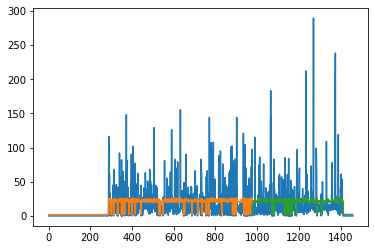

In [23]:

# plot baseline and predictions
#plt.plot(scaler.inverse_transform(dataset_scaled))
plt.plot(dataset_scaled)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()